In [62]:
from Utilities import *
import torch

import h5py
import pandas as pd
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d

from PIL import Image

from tqdm.notebook import tqdm

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def plot_abp(abp_data):

   # Plotting the two 1D arrays with different colors
    plt.figure(figsize=(10, 6))
    plt.plot(abp_data, label='ABP Data')
    plt.grid(True)
    plt.show()

def display_image(image):
	plt.imshow(image, cmap='viridis', aspect='auto')
	plt.title('1D Signal Represented in 64x64 Image')
	plt.show()

In [3]:
hdf5_file_path = '/home/ms5267@drexel.edu/moberg-precicecap/data/Patient_2021-12-21_04_16.h5'
annotation_path = '/home/ms5267@drexel.edu/moberg-precicecap/data/20240207-annotations-export-workspace=precicecap-patient=7-annotation_group=90.csv'
annotation_metadata = {
    'modality':'ART'
    ,'location':'na'
    ,'scale_wrt_hd5':1e3
}
segment_length_sec = 3

data_group_name='Waveforms/ART_na'
timestamp_group_name='Waveforms/ART_na_Timestamps'
sampling_frequency=125

df_annotation = pd.read_csv(annotation_path)
df_annotation_filtered = df_annotation[(df_annotation['modality']==annotation_metadata['modality']) & (df_annotation['location']==annotation_metadata['location'])]

artifacts = df_annotation_filtered[["start_time","end_time"]].to_numpy() * int(annotation_metadata['scale_wrt_hd5'])

In [4]:
with h5py.File(hdf5_file_path, 'r') as file:
    dataset = file[data_group_name]
    timestamp = file[timestamp_group_name]

    data, timestamp = dataset[:], timestamp[:]

In [8]:
artifact_raw = []
for art in artifacts:
	start_idx = np.searchsorted(timestamp, art[0], side='left')
	end_idx = np.searchsorted(timestamp, art[1], side='left')
	# For 125Hz, the sample_len is 1250 for 10sec sample
	##################################################

	interval_data = data[start_idx:end_idx]
	artifact_raw.append(interval_data)
	

In [17]:
# Now filter the artifacts whose more than 50% data is less than zero
# Calculate the percentage < 0 in the array
artifact_raw_clean = []
for arr in artifact_raw:
	percentage = (np.sum(arr < 0) / arr.size) * 100

	# Check if the percentage is greater than 30%
	if percentage >= 50:
		count_less_than_zero = np.sum(arr < 0)
		print(f"Out of {arr.shape}, {count_less_than_zero} are negative values")
	else:
		artifact_raw_clean.append(arr)
    

Out of (7496,), 5140 are negative values
Out of (915701,), 855434 are negative values
Out of (1874,), 1202 are negative values
Out of (4997,), 3261 are negative values


/tmp/ipykernel_416966/707838372.py:5: RuntimeWarning: invalid value encountered in scalar divide
  percentage = (np.sum(arr < 0) / arr.size) * 100


#### Now get the pulses, interpolate to 64 points, normalize to 0-1 and convert to image

In [78]:
def get_pulses(signal, sigma=2):
	filtered_signal = gaussian_filter1d(signal, sigma=sigma)

	troughs, _ = scipy.signal.find_peaks(-filtered_signal)
	pulses = []
	for i in range(len(troughs)-1):
		s=signal[troughs[i]:troughs[i+1]]
		
		if len(s)>0 and not np.isnan(s).any():
			pulses.append(s)
	
	return pulses
    

In [79]:
def interpolate_and_normalize(signal):
	# Original indices
	x_original = np.arange(len(signal))

	# New indices for the desired length of 64
	x_new = np.linspace(0, len(signal) - 1, 64)

	# Perform cubic spline interpolation
	cs = scipy.interpolate.CubicSpline(x_original, signal)
	interpolated_array = cs(x_new)

	# Normalize the interpolated array to have values between 0 and 1
	normalized_array = (interpolated_array - interpolated_array.min()) / (interpolated_array.max() - interpolated_array.min())

	return normalized_array

In [80]:
def convert_1d_into_image(signal):
	image=np.zeros((64,64))
	for x,y in enumerate(signal):
		print(x,y)
		image[x][int(y*63)]=1
	
	image = np.rot90(image, k=1)

	return image
	

0 0.6152902469986629
1 0.6214879075972395
2 0.6285662794022806
3 0.6363093351381217
4 0.6445010475290953
5 0.6529253892995356
6 0.6613663331737754
7 0.6696078518761488
8 0.6774339181309894
9 0.6846285046626314
10 0.6909755841954075
11 0.6962591294536515
12 0.7002722921260525
13 0.7029802869877524
14 0.7045011415723237
15 0.7049581953140073
16 0.7044747876470456
17 0.7031742580056789
18 0.7011971190617178
19 0.698803648562141
20 0.6963051257070676
21 0.694013018154637
22 0.6922387935629933
23 0.6912939211075407
24 0.6914924857264189
25 0.6931565546824447
26 0.696609712502199
27 0.7021755437122639
28 0.710177632839223
29 0.7209347191743161
30 0.7345294124927473
31 0.7507066702319378
32 0.7691854823961595
33 0.7896848389896807
34 0.811923730016773
35 0.8356012110393415
36 0.8601571317506278
37 0.8848500720895355
38 0.9089348924488693
39 0.9316664532214348
40 0.952299614800037
41 0.9701025008495096
42 0.9844130131088197
43 0.994591919197912
44 1.0
45 0.9999980363982995
46 0.993947292167325

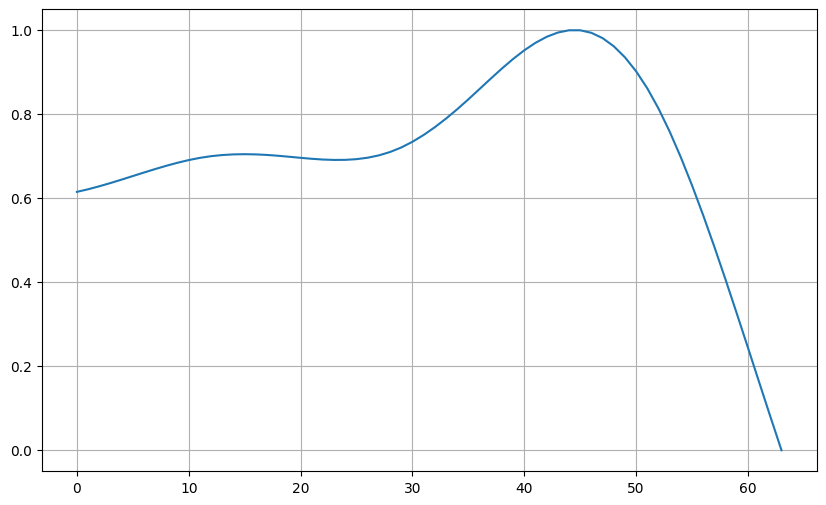

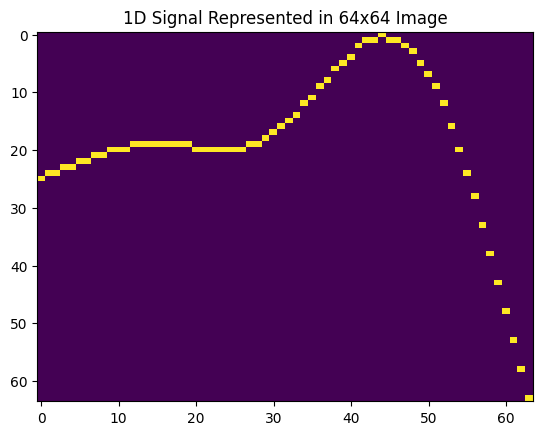

In [81]:
signal=artifact_raw_clean[0]
pulses = get_pulses(signal)

p = pulses[0]
d = interpolate_and_normalize(pulses[1])
image = convert_1d_into_image(d)

plot_abp(d)
display_image(image)

In [82]:
for signal in tqdm(artifact_raw_clean):
	pulses = get_pulses(signal)

	for p in pulses:
		d = interpolate_and_normalize(p)
		image = convert_1d_into_image(d)
		
		image_to_save = Image.fromarray(image.astype('uint8'), 'L')

		



  0%|          | 0/219 [00:00<?, ?it/s]

0 0.0
1 0.03354759469874296
2 0.07441581252183259
3 0.12166858017276276
4 0.17436982435502474
5 0.2315834717721119
6 0.29237344912751756
7 0.35580368312473454
8 0.4209381004672547
9 0.48684062785857135
10 0.5525625867166495
11 0.6171048773173401
12 0.6794557946509686
13 0.7386036337078588
14 0.793542992121097
15 0.8434134283073469
16 0.8874994614668421
17 0.9250919134425838
18 0.9554816060775699
19 0.9780948298678386
20 0.9928997499215736
21 1.0
22 0.999499213864339
23 0.9915174872502127
24 0.9765535413044042
25 0.9554847225848544
26 0.9292048396239082
27 0.8986077009539051
28 0.86462388959701
29 0.8283310865346734
30 0.7908437472381672
31 0.7532763271787649
32 0.7167271565278116
33 0.6819236835583332
34 0.6492224746450385
35 0.6189639708627056
36 0.5914886132861147
37 0.5670169126776542
38 0.5452896585501376
39 0.5259277101039881
40 0.508551926539628
41 0.49278124118284333
42 0.4781902922427911
43 0.46430942281199694
44 0.45066705010835156
45 0.43679159134974627
46 0.4222432306997605


/tmp/ipykernel_416966/1630259237.py:13: RuntimeWarning: invalid value encountered in divide
  normalized_array = (interpolated_array - interpolated_array.min()) / (interpolated_array.max() - interpolated_array.min())


ValueError: cannot convert float NaN to integer